In [86]:
# import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load data
data = pd.read_csv('abs_res_data_2.csv')

In [90]:
data.sample(7)
#data.info()

,measure,region,obs_value,unit_of_measure,unit_of_multiplier,date
1996,Mean price of residential dwellings,Western Australia,5.596000e+05,Australian Dollars,Thousands,2015-07-01
1345,Number of residential dwellings,Australia,1.007180e+07,Number,Thousands,2017-10-01
2433,Mean price of residential dwellings,Queensland,4.610000e+05,Australian Dollars,Thousands,2014-10-01
453,Mean price of residential dwellings,New South Wales,6.935000e+05,Australian Dollars,Thousands,2014-10-01
1198,Value of dwelling stock: Owned by non households,Victoria,7.146740e+10,Australian Dollars,Millions,2022-04-01
2374,Value of dwelling stock: Owned by all sectors,New South Wales,1.800657e+12,Australian Dollars,Millions,2013-10-01
2392,Value of dwelling stock: Owned by all sectors,New South Wales,2.784582e+12,Australian Dollars,Millions,2018-04-01


In [88]:
# lower case and place _between words
data.drop(columns=["MEASURE"], inplace=True)
data.drop(columns=["REGION"], inplace=True)
data.columns = (
    data.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace(r"[^\w\s]", "", regex=True)
)

# remove columns with at least 1 null
data = data.dropna(axis=1, how="any")

# keep only relevant columns
keep_cols = ["measure", "region", "time_period", "obs_value", "unit_of_measure", "unit_of_multiplier"]
data = data[keep_cols]

In [89]:
scale_map = {
    "Units": 1,
    "Thousands": 1_000,
    "Millions": 1_000_000,
}

data["obs_value"] = data["obs_value"] * data["unit_of_multiplier"].map(scale_map)

data["year"] = data["time_period"].str[:4].astype(int)
data["quarter"] = data["time_period"].str[-2:]

# Map quarter to month (start of quarter)
q_map = {"Q1": 1, "Q2": 4, "Q3": 7, "Q4": 10}
data["month"] = data["quarter"].map(q_map)

# Create datetime column
data["date"] = pd.to_datetime(dict(year=data["year"], month=data["month"], day=1))

# Optional cleanup
data.drop(columns=["time_period", "year", "quarter", "month"], inplace=True)

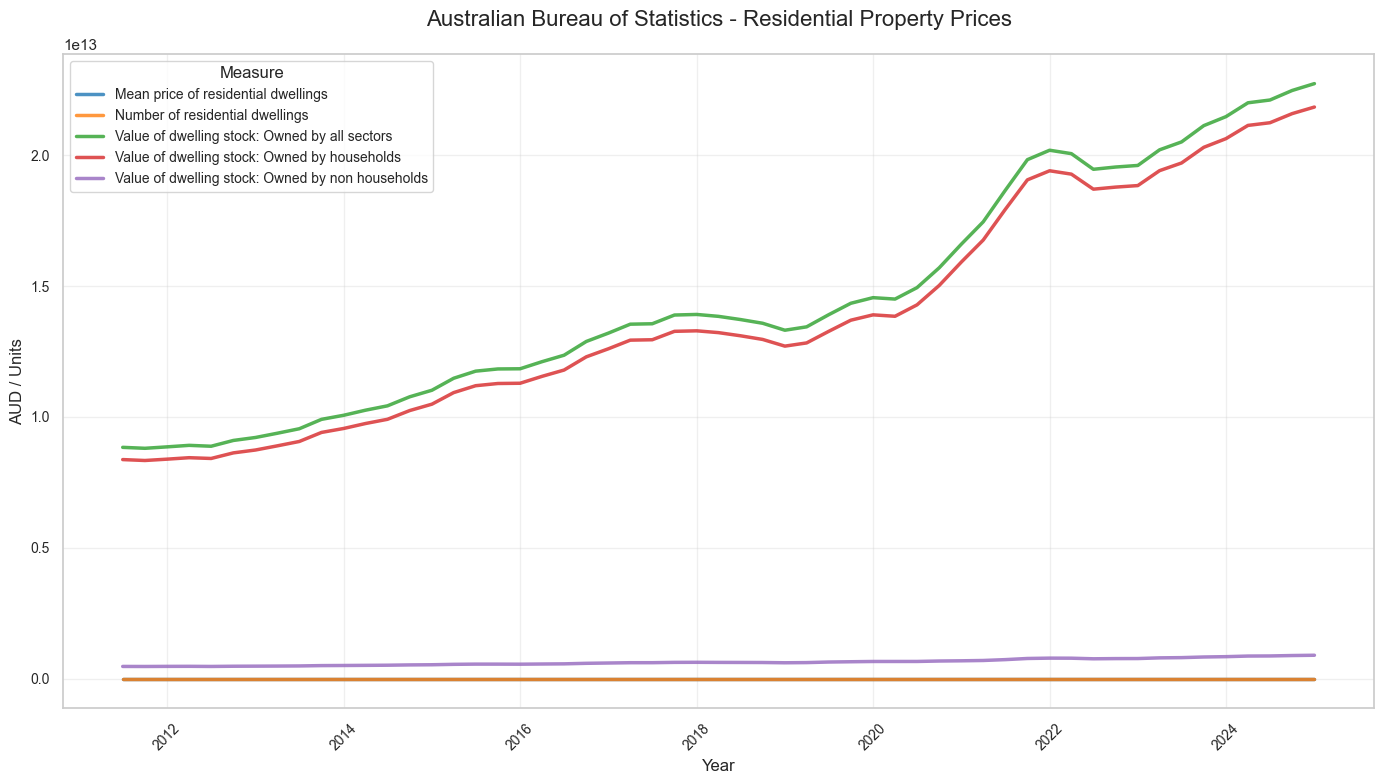

In [121]:
# build the plot data
plot_df = (
    data.groupby(["date", "measure"])["obs_value"]
    .sum()
    .unstack()
)


sns.set_theme(style="whitegrid", context="notebook")
plt.figure(figsize=(14, 8))
colors = sns.color_palette("tab10", n_colors=len(plot_df.columns))
for i, column in enumerate(plot_df.columns):
    plt.plot(plot_df.index, plot_df[column], 
             label=column, 
             linewidth=2.5, 
             alpha=0.8,
             color=colors[i])

plt.title("Australian Bureau of Statistics - Residential Property Prices", fontsize=16, pad=20)
plt.ylabel("AUD / Units", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.legend(title="Measure", fontsize=10, title_fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()

## Overview of Residential Property Prices

This graph displays multiple property price measures from the Australian Bureau of Statistics over time. Each line represents a different measure (mean price, median price, number of dwellings, etc.) across all regions of Australia.

**Key observations:**
- All price measures show a general upward trend over the time period, indicating Australia's consistently rising property market
- The separation between different measures shows the varying ways to quantify the housing market
- There appears to be some cyclical patterns, with periods of faster growth followed by plateaus
- The graph combines both price metrics (in AUD) and count metrics (number of dwellings), which operate on different scales

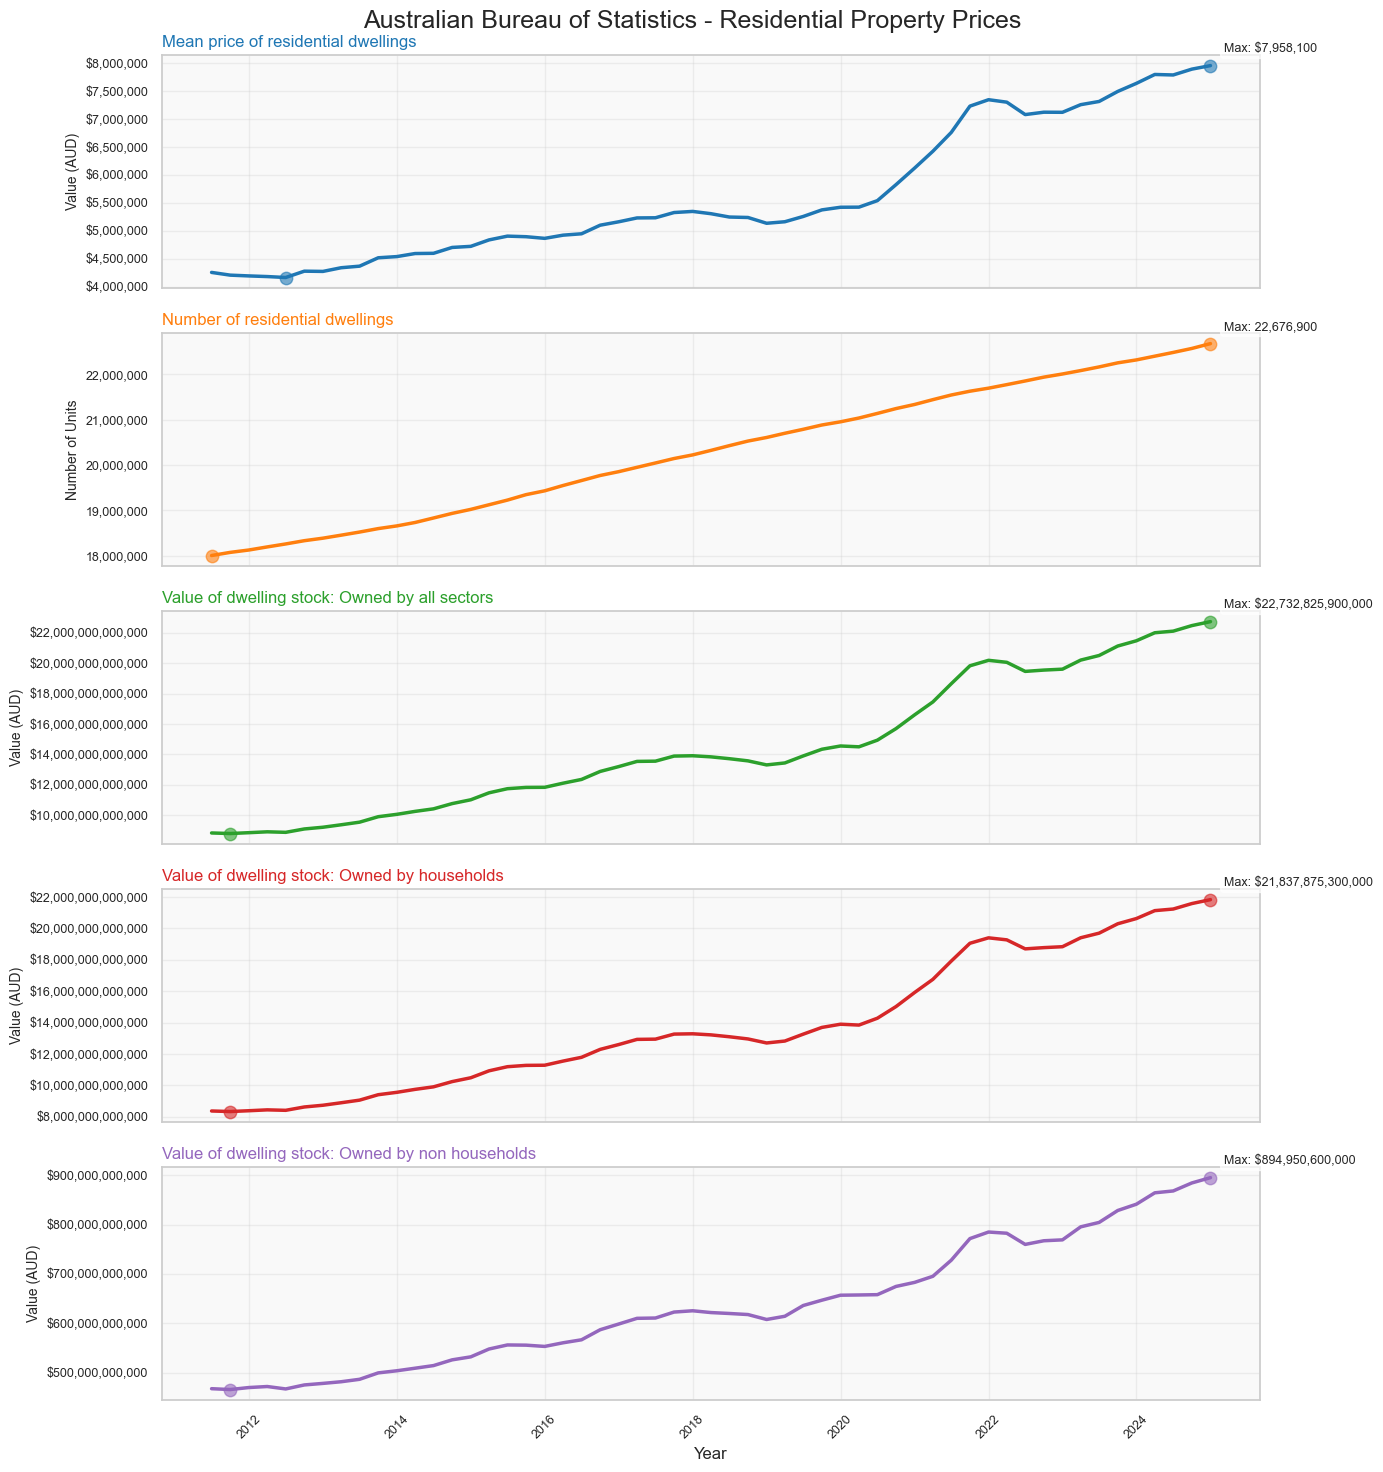

In [123]:
plot_df = (
    data.groupby(["date", "measure"])["obs_value"]
    .sum()
    .unstack()
)

# Set up a subplot grid - one row per measure
n_measures = len(plot_df.columns)
fig, axes = plt.subplots(n_measures, 1, figsize=(14, 3*n_measures), sharex=True)
fig.suptitle("Australian Bureau of Statistics - Residential Property Prices", fontsize=18, y=0.98)

# Use a consistent color palette
colors = sns.color_palette("tab10", n_colors=n_measures)

# Format functions for y-axis
from matplotlib.ticker import FuncFormatter
dollar_formatter = FuncFormatter(lambda x, p: f'${x:,.0f}')
number_formatter = FuncFormatter(lambda x, p: f'{x:,.0f}')

# Plot each measure in its own subplot
for i, measure in enumerate(plot_df.columns):
    # Plot the data
    axes[i].plot(plot_df.index, plot_df[measure], 
                linewidth=2.5, 
                color=colors[i])
    
    # Add title and styling to each subplot
    axes[i].set_title(measure, fontsize=12, color=colors[i], loc='left')
    
    # Use different formatting based on measure type
    if "number of" in measure.lower():
        axes[i].set_ylabel("Number of Units", fontsize=10)
        axes[i].yaxis.set_major_formatter(number_formatter)
        # For min/max annotations
        value_prefix = ""
    else:
        axes[i].set_ylabel("Value (AUD)", fontsize=10)
        axes[i].yaxis.set_major_formatter(dollar_formatter)
        # For min/max annotations
        value_prefix = "$"
    
    axes[i].grid(True, alpha=0.3)
    
    # Add subtle background
    axes[i].set_facecolor('#f9f9f9')
    
    # Highlight min and max points
    max_idx = plot_df[measure].idxmax()
    min_idx = plot_df[measure].idxmin()
    max_val = plot_df[measure].max()
    min_val = plot_df[measure].min()
    
    axes[i].scatter(max_idx, max_val, color=colors[i], s=80, zorder=5, alpha=0.6)
    axes[i].scatter(min_idx, min_val, color=colors[i], s=80, zorder=5, alpha=0.6)
    
    # Optional annotations for max/min points with correct formatting
    axes[i].annotate(f'Max: {value_prefix}{max_val:,.0f}', 
                    xy=(max_idx, max_val),
                    xytext=(10, 10),
                    textcoords='offset points',
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
    
    # Customize tick parameters
    axes[i].tick_params(axis='y', labelsize=9)

# Set x-axis label only on the bottom subplot
axes[-1].set_xlabel("Year", fontsize=12)
axes[-1].tick_params(axis='x', labelsize=9, rotation=45)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for the figure title
plt.show()

## Detailed View of Individual Property Measures

This multi-panel visualization separates each measure into its own subplot, allowing for better comparison of trends without scale interference. Each measure is displayed with its own y-axis scale, appropriate units, and highlighting of minimum and maximum points.

**Key observations:**
- Separating the measures reveals distinct patterns that were difficult to see in the combined plot
- The highlighted maximum values show when each measure peaked
- Price measures (showing dollar values) and count measures (showing units) can now be properly interpreted with their correct units
- The synchronized x-axis across all subplots allows for temporal comparison between different measures
- This presentation makes it easier to identify which measures are most volatile versus which show steady growth

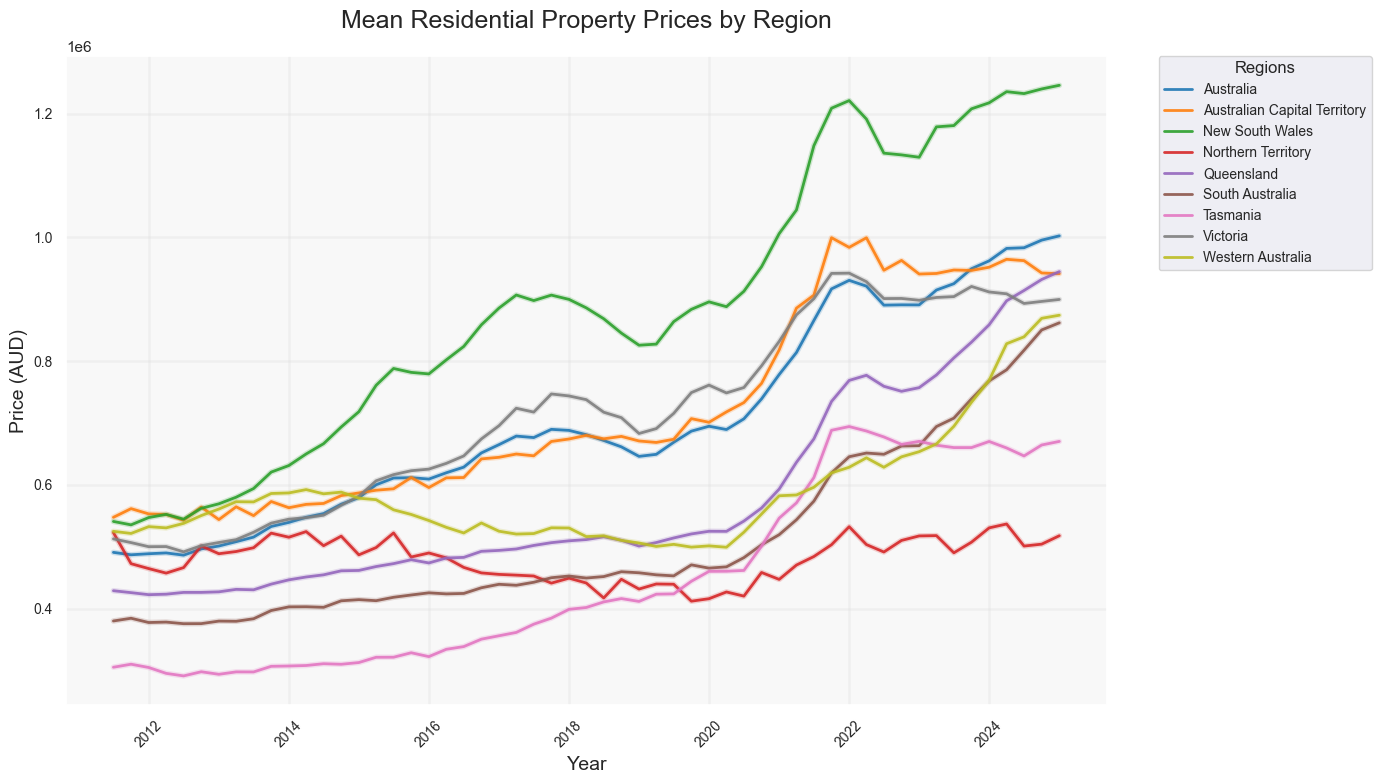

In [109]:
mean_price = data[data["measure"] == "Mean price of residential dwellings"]
mean_pivot = mean_price.pivot(index="date", columns="region", values="obs_value")

sns.set_style("darkgrid")
plt.figure(figsize=(14, 8))
colors = sns.color_palette("tab10", n_colors=len(mean_pivot.columns))
plt.grid(True, which='major', color="#DDDDDD", linewidth=1.8)
plt.grid(True, which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

for i, region in enumerate(mean_pivot.columns):
    plt.plot(mean_pivot.index, mean_pivot[region], 
             linewidth=4, alpha=0.2, color=colors[i])
    plt.plot(mean_pivot.index, mean_pivot[region], 
             label=region, 
             linewidth=2, 
             alpha=0.9,
             color=colors[i])

ax = plt.gca()
ax.set_facecolor('#f8f8f8')  # Light gray background

    
plt.title("Mean Residential Property Prices by Region",fontsize=18, pad=20)
plt.ylabel("Price (AUD)", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, 
           frameon=True, fontsize=10, title="Regions")

plt.tight_layout()
plt.show()

## Regional Comparison of Mean Residential Property Prices

This visualization compares mean residential property prices across different regions of Australia, using a combination of thicker translucent lines and thinner solid lines to enhance visibility where lines overlap.

**Key observations:**
- There is significant regional variation in property prices across Australia
- New South Wales and Victoria consistently maintain the highest mean property prices
- Most regions follow similar trend patterns, suggesting national economic factors influence all markets
- The price gap between highest and lowest-priced regions has widened over time
- Some regions show more volatility than others, potentially reflecting local economic conditions
- The visualization technique using both thick translucent and thin solid lines helps distinguish between regions even when trend lines cross